# CS 505 Homework 05:  Recurrent Neural Networks

#### Due Friday  11/17 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%. 

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem. 

Note: This homework is a bit different from the first four in this class in that in some parts we are specified **what** you need to do for your solutions, but much less of the **how** you write the details of the code. There are three reasons for this:

- In a graduate level CS class, after four homeworks and two months of lectures, you should be well-equipped to work out the coding issues for yourself, and in general, going forward, this is how you will solve the kinds of problems presented here; 
- Suggestions for resources (mostly ML blogs) will be suggested; there are many resources, but these are from bloggers that I trust and have used in the past;
- I am expecting that you will make good use of chatGPT for help with the details of syntax and low-level organization of your code. There is often nothing very stimulating or informative about precisely what is the syntax needed for a particular kind of layer in a network, and rather than poke around on StackOverflow, chatGPT is particularly good at summarizing existing approaches to ML coding tasks. 

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW05.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW05.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late. 

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received. 

A few brief sentences is all that I am looking for here. 

    <Your answer here>

In [1]:
import math
import random

import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import spacy
import nltk
from nltk.corpus import gutenberg, brown
import pickle
import os
import random

In [2]:
from typing import List
from typing import Dict
from typing import Any
from typing import Union
from typing import DefaultDict

In [3]:
"""
This cell contains some helpful methods to dump notebook variables
to a file so you don't have to rerun expensive computations every
time.
"""

from typing import Union

def does_var_exists(var_name: str) -> bool:
    return os.path.isfile(F'./data/pickle/{var_name}.pkl')

def dump_var(var_name: str, obj) -> None:
    with open(F'./data/pickle/{var_name}.pkl', 'wb') as file:
        pickle.dump(obj, file)

def load_var(var_name: str) -> Union[None, object]:
    if not does_var_exists(var_name):
        return None
    with open(F'./data/pickle/{var_name}.pkl', 'rb') as file:
        return pickle.load(file)

In [4]:
# create dirs where I'll be storing my data
os.makedirs('./data/glove', exist_ok=True)
os.makedirs('./data/java', exist_ok=True)
os.makedirs('./data/pickle', exist_ok=True)

## Problem One:  Character-Level Generative Model (20 pts)

A basic character-level model has been provided on the class web site in the row for Lecture 14: 
<a href="https://www.cs.bu.edu/fac/snyder/cs505/CharacterLevelLSTM.ipynb">IPYNB</a>. Your first step is to download this and run it in Colab (or download the data file, which is in the CS 505 Data Directory and also linked on the web site, and run it on your local machine) and understand all its various features. Most of it is straight-forward at this point in the course, but the definition of the model is a bit messy, and you will need to read about LSTM layers in the Pytorch documents to really understand what it is doing and what the hyperparameters mean. 

Also take a look at the article "The Unreasonable Effectiveness of Recurrent Neural Networks" linked with lecture 14. 

For this problem, you will run this code on a dataset consisting of Java code files, which has been uploaded to the CS 505 Data Directory and also to the class web site: <a href="https://www.cs.bu.edu/fac/snyder/cs505/JavaFiles/">DIR</a>  Select some number of these files and concatenate them into one long text file, such that you have approximately 10-20K characters (if you have trouble running out of RAM you can use fewer, but try to get at least 10K). 

You will run the character-level model on this dataset. You may either cut and paste code into this notebook, or submit the file with your changes and output along with this notebook to Gradescope.

Your task is to get a character-level model that has not simply memorized the Java text file by overfitting, and does not do much other than spit out random characters (underfitting).  You will get the former if you simply run it for many epochs without any changes to the hyperparameters; you will get the latter if you run it only a few epochs. 

You should experiment with different hyperparameters, which in the notebook are indicated
by 

          <== something to play with

and try to get a model that seems to recognize typical Java syntax such as comments, matching parentheses, expressions, assignments, and formatting, but is not just repeating
exact text from the data file. Clearly, the number of epochs plays a crucial role, but I also want you to
experiment with the various hyperparameters to try to avoid overfitting. See my lectures on T 10/31 and Th 11/2 (recorded and on my YT channel) for the background to this.

Note that the code you will work from does not use validation and testing sets, nor does it calculate the accuracy, but only tracks the loss. The nature of the data sets for character-level models does not seem to lend itself to accuracy metrics, but you may wish to try this -- I have not found it to be useful, but have simply focussed on the output and "eyeballed" the results to determine how much they have generalized
from the data. 

Submit your notebook(s) to Gradescope as usual, and also provide a summary of your results in the next cell. 


In [600]:
# load the java sources
java_source_list = []
num_chars = 0

files = os.listdir('./data/java/')
random.shuffle(files)
for java_file in files:
    # only add full files (because I don't want training code that doesn't have closing brackets
    with open('./data/java/' + java_file, 'r') as file:
        lines = file.readlines()
        num_chars += len('\n'.join(lines))
        # don't go over 32k characters (note: I deviate a bit from the "10k to 20k" suggestion)
        if num_chars > 32000:
            break
        java_source_list += lines

java_source_text = '\n'.join(java_source_list)

In [601]:
print(f"Text is {len(java_source_text)} characters long.")
print(f"First 200 characters: {java_source_text[:200]}")

Text is 31509 characters long.
First 200 characters: /* File: RecursiveGraphics.java

 * Author: 

 * Date: 

 * Purpose: This is the template for PS5, Problem 6

 */



import java.awt.Color;

import java.awt.Canvas;

import java .awt.Graphics;

import


In [602]:
# do some cleaning
cleaned_java_source_text = java_source_text
# remove double new lines
cleaned_java_source_text = re.sub("\n\n", "\n", cleaned_java_source_text)
# remove lines with only whitespace
cleaned_java_source_text = re.sub(r'^\s*$', "", cleaned_java_source_text)

In [603]:
print(f"First 200 characters (cleaned): {cleaned_java_source_text[:200]}")

First 200 characters (cleaned): /* File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Problem 6
 */

import java.awt.Color;
import java.awt.Canvas;
import java .awt.Graphics;
import javax.sw


In [604]:
chars_in_text = sorted(list(set(cleaned_java_source_text)))
num_chars = len(chars_in_text)

print(f'There are {num_chars} unique characters in the text.')
print(f'Character set: {chars_in_text}.')

There are 89 unique characters in the text.
Character set: ['\t', '\n', ' ', '!', '"', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}'].


In [605]:
# Create functions mapping characters to integers and back

def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i]

In [606]:
# HYPER PARAMETERS HERE
sample_len = 160 # <== something to play with
batch_size = 512 # <== something to play with
model_dropout= 0.4 # <== something to play with
hidden_dim_size = 316 # <== something to play with
n_layers_count = 3 # <== something to play with
leaning_rate = 0.001 # <== something to play with
weight_decay = 0.00015 # <== something to play with
model_temp = 0.7 # <== something to play with

In [607]:
# Creating lists that will hold our input and target sample sequences

input_seq_chars = []
target_seq_chars = []

for k in range(len(cleaned_java_source_text)-sample_len+1):

    # Remove last character for input sequence
    input_seq_chars.append(cleaned_java_source_text[k:k+sample_len-1])

    # Remove firsts character for target sequence
    target_seq_chars.append(cleaned_java_source_text[k+1:k+sample_len])

for i in range(5):
    print(f'Input sequence:\n{input_seq_chars[i]}')
    print(f'Target sequence:\n{target_seq_chars[i]}')
    print()

Input sequence:
/* File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Problem 6
 */

import java.awt.Color;
import java.awt.Canvas;
i
Target sequence:
* File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Problem 6
 */

import java.awt.Color;
import java.awt.Canvas;
im

Input sequence:
* File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Problem 6
 */

import java.awt.Color;
import java.awt.Canvas;
im
Target sequence:
 File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Problem 6
 */

import java.awt.Color;
import java.awt.Canvas;
imp

Input sequence:
 File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Problem 6
 */

import java.awt.Color;
import java.awt.Canvas;
imp
Target sequence:
File: RecursiveGraphics.java
 * Author: 
 * Date: 
 * Purpose: This is the template for PS5, Proble

In [608]:
# convert an integer into a one-hot encoding of the given size (= number of characters)
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')

# do the same thing, but for a list/array of integers
def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

In [609]:
input_seq = []
for i in range(len(input_seq_chars)):
    input_seq.append( [char2int(ch) for ch in input_seq_chars[i]])
input_seq = seq2OneHot(input_seq,size=num_chars)

In [610]:
target_seq = []
for i in range(len(input_seq_chars)):
    target_seq.append([char2int(ch) for ch in target_seq_chars[i]])
target_seq = seq2OneHot(target_seq,size=num_chars)

In [611]:
print('input shape:', input_seq.shape)
print('target shape:', target_seq.shape)

input shape: (30480, 159, 89)
target shape: (30480, 159, 89)


In [612]:
input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

In [613]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)
ds.__len__()

30480

In [614]:
data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [615]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [616]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        hidden_state_size = x.size(0)

        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()

        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out

In [617]:
# Instantiate the model with hyperparameters

model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=hidden_dim_size, n_layers=n_layers_count,dropout=model_dropout)

print(model)

model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=leaning_rate,weight_decay=weight_decay)

Model(
  (lstm): LSTM(89, 316, num_layers=3, batch_first=True, dropout=0.4)
  (fc1): Linear(in_features=316, out_features=89, bias=True)
)


In [618]:
losses = []

In [625]:
num_epochs = 25
model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in data_loader:
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

100%|██████████| 4/4 [01:34<00:00, 23.74s/it]


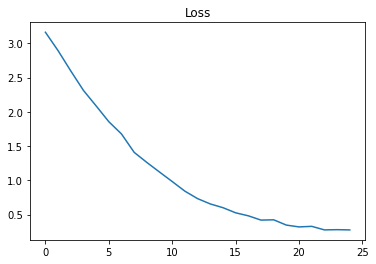

In [626]:
plt.title('Loss')
plt.plot(losses)

In [631]:
#file_path = './data/pickle/final_model.torch'
#torch.save(model, file_path)
#dump_var("losses", losses)

In [627]:

def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

print("Example of softmax with temperature.")
dist = [0.1, 0.3, 0.6]
print('distribution:',dist)
print(softmax_with_temperature(dist,0.01))
print(softmax_with_temperature(dist,0.1))
print(softmax_with_temperature(dist,0.2))
print(softmax_with_temperature(dist,0.3))
print(softmax_with_temperature(dist,1))
print(softmax_with_temperature(dist,10))

Example of softmax with temperature.
distribution: [0.1, 0.3, 0.6]
[1.9287498479637375e-22, 9.3576229688393e-14, 0.9999999999999064]
[0.006377460922442302, 0.04712341652466416, 0.9464991225528936]
[0.06289001324586753, 0.1709527801977903, 0.7661572065563421]
[0.12132647558421489, 0.23631170657656433, 0.6423618178392208]
[0.2583896517379799, 0.3155978333128144, 0.4260125149492058]
[0.3255767455856355, 0.3321538321280155, 0.3422694222863489]


In [628]:
temperature = model_temp

def predict(model, ch):

    # only look at last sample_len - 1 characters

    ch = ch[-(sample_len - 1):]

    # One-hot encoding our input to fit into the model
    ch = np.array([char2int(c) for c in ch])
    ch = np.array([int2OneHot(ch, num_chars)])
    ch = torch.from_numpy(ch).to(device)

    out = model(ch)

    # take the probability distribution of the last character in the sequence produced by the model
    prob = softmax_with_temperature(out[-1],temperature)

    # Choosing a character based on the probability distribution, with temperature
    char_ind = choice(list(range(num_chars)), p=prob)

    return int2char(char_ind)

predict(model,"public static ")

'\n'

In [629]:
def sample(model, out_len, start):
    model.eval() # eval mode
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [630]:
print(sample(model, 2000, "public static "))

public static void drawSpiralHelper(double x, double y, double s, boolean horizontal, int depth, Graphics g) {
 	
	if(depth == 0) {
           return;
       }
       
       // draw lines
       
       double x1 = x0 + len * Math.cos(angle);
       double y1 = y0 - len * Math.sin(angle);
 
       drawLine(x0,y0,x1,y1,g);
       
       for (int i = 0; i < rDelta.length; ++i) {
          changeColorByRecursionDepth(depth); 
          drawTreeHelper(x1, y1, len * lenDelta[i], angle + thetaDelta[i], depth-1,g);
       }
   }




    //  Problem 6.1    Your Turn!
    //  For this one, you have to figure aut how to do the recursive cales on tem .
    public void drawLine(double x1, double y1, double x5, double y5, int depth, Graphics g) {
       if (depth == 2) {
	    drawLine(x1, y1, x5, y5, g);
       }
       else {
           
           double x2, x3, x4;
           double y2, y1, y3, y5;  
            
           double deltaX = x5 - x1;
           double deltaY = y5 - x1;
         

### Your analysis

Please describe your experiments and cut and paste various outputs to show how the model performed at
various numbers of epochs and with various hyperparameters. What characteristics of Java was it able to learn? What did it not learn? The article "The Unreasonable ..." does a nice job of showing this kind of behavior as the number of epochs increases, and you might look at it before writing your answer here. 

My goal going into this was to create a model that understands Java syntax (including at the very least, opening and closing brackets) as stated in the problem.

Starting with the example code in the CharacterLevelLSTM.ipynb, my first attempts to get an effective model were disappointing. With my initial hyperparameters copied from the CharacterLevelLSTM.ipynb, my model was memorizing things way too quick (in less than 20 epochs). Here were some results from 50 epochs:
Code Generations: https://share.aseef.dev/bDfMCkP
Losses: https://share.aseef.dev/WHcLkjc

In order to prevent memorization I played around with several things:
a) Used drop-out rates from 30%-50% to prevent memorization
b) Played around with layers low as 1 and deep as 6 in hopes the model can better extract abstract info
c) Increased batch size (though this was just to train faster as my model size grew)
d) Reduced the number of feature states by half in hopes that the model won't have enough states to memorize the data (from 96-256) - but this didn't work well in practice.
e) Also played around with the sample lengths and found though higher sample lengths took longer to train, they produced higher quality models

In this experimentation, the challenges I encountered were that the dropout rates were simply too high on one spectrum and the model just stopped learning after one point (no matter how many more epochs I would train it for):
Code Generation: https://share.aseef.dev/coGIakH
Losses: https://share.aseef.dev/Er2mKLm

But simply just reducing dropout rates didn't help much either (with a dropout rate of 0.3):
Code Generation: https://share.aseef.dev/LMdsJCE
Losses: https://share.aseef.dev/rHDRPH7

In the end, nothing worked and I was not able to produce any "decent" models. My models were either garbage, or memorized. That was until I took a page from "the unreasonable effectiveness of data" and simply added about 50% more data by increasing my data size to up to 32k characters!

My final model finally produces outputs that aren't fully memorized and finally starts to demonstrate some understanding of brackets, indenting (mostly), methods, function calls and etc. In fact, the model went beyond my expectation and the code it wrote was still relevant to the name of the method (e.i. wasn't making just completely random calls).
Code Generation: https://share.aseef.dev/i9WE5Tg
Losses: https://share.aseef.dev/NoAtm44

I think the final drop out rates I ended up using (at 40%) was also an important choice that helped the model finally generalize to a satisfactory model.


## Problem Two:  Word-Level Generative Model (40 pts)

In this problem you will write another generative model, as you did in HW 03, but this time you will use an LSTM network, GloVe word embeddings, and beam search. 

Before you start, read the following blog post to see the core ideas involved in creating a generative model using word embeddings:

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

You may also wish to consult with chatGPT about how to develop this kind of model in Pytorch.

The requirements for this problem are as follows (they mostly consist of the extensions proposed at
the end of the blog post linked above):

- Develop your code in Pytorch, not Keras
- Use the novel *Persuation* by Jane Austen as your training data (available through the Brown Corpus); if you have trouble with RAM you will need to cut down the number of sentences (perhaps by eliminating the longest sentences as well, see next point). 
- Develop a sentence-level model by padding sentences to the maximum sentence length in the novel (if this seems extreme, you may wish to delete a small number of the longest sentences to reduce the maximum length). Surround your data sentences with `<s>` and `</s>` and your model should generate one sentence at a time (as you did in HW 03), i.e., it should stop if it generates the `</s>` token. 
- Use pretrained GLoVe embeddings with dimension 200, and update them (refine by training further) on the sentences in the novel; if you have trouble with RAM you may use a smaller dimension. 
- Experiment with the hyperparameters (sample length, number of layers, uni- or bi-directional, weight_decay, dropout, number of epochs, temperature of the softmax, etc.) as you did in Problem One to find the "sweet spot" where you are generating interesting-looking sentences but not simply repeating sentences from the data. You may want to try adding more linear layers on top to pick the most likely next word. 
- Generate sentences using Beam Search, which we describe below. 

Your solution should be the code, samples of sentences generated with their score (described below), and your description of the investigation of various hyperparameters, and what strategy ended up seeming to generate the most realistic sentences that were not simply a repeat of sentences in the data. 


In [5]:
#if does_var_exists('persuasion_doc'):
#    persuasion_doc = load_var('persuasion_doc')
#else:
# download it from gutenberg
nltk.download('gutenberg')
# Load the text of Persuasion by Jane Austen
persuasion_raw_text = gutenberg.raw('austen-persuasion.txt')
# Tokenize the text into sentences
#spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")
persuasion_doc = nlp(persuasion_raw_text)
dump_var('persuasion_doc', persuasion_doc)

[nltk_data] Downloading package gutenberg to
[nltk_data]     /usr4/cs505ws/aseef/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [6]:
print(f"The novel is {len(persuasion_raw_text)} characters long with {len(set(persuasion_raw_text.lower()))} uncased unique characters {set(persuasion_raw_text.lower())}.")

The novel is 466292 characters long with 53 uncased unique characters {'i', '2', 't', '`', '4', ']', 'g', '3', '9', "'", 'u', '(', 'k', '"', 'x', '1', 'e', ',', ':', 'p', 's', '8', 'f', '5', 'z', 'a', 'r', ';', ' ', '0', '!', 'h', 'l', 'n', ')', 'd', '.', 'c', 'q', '?', 'j', '\n', 'w', 'b', '[', '-', 'o', '6', 'y', 'v', '7', 'm', '&'}.


In [7]:
# convert doc to a string list of sentences
persuasion_sentences: List[List[str]] = []
for sent in persuasion_doc.sents:
    persuasion_sentences += [sent.__str__()]

In [8]:
# print first 3 sentences to confirm stuff works
for sent in persuasion_sentences[:3]:
    print(sent)

[Persuasion by Jane Austen 1818]


Chapter 1


Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who,
for his own amusement, never took up any book but the Baronetage;
there he found occupation for an idle hour, and consolation in a
distressed one; there his faculties were roused into admiration and
respect, by contemplating the limited remnant of the earliest patents;
there any unwelcome sensations, arising from domestic affairs
changed naturally into pity and contempt as he turned over
the almost endless creations of the last century; and there,
if every other leaf were powerless, he could read his own history
with an interest which never failed.  
This was the page at which
the favourite volume always opened:

           "ELLIOT OF KELLYNCH HALL.


"Walter Elliot, born March 1, 1760, married, July 15, 1784, Elizabeth,
daughter of James Stevenson, Esq. of South Park, in the county of
Gloucester, by which lady (who died 1800) he has issue Elizabeth,
born June 1, 1785; A

In [9]:
# lets clean up the sentences...
persuasion_cleaned_sentences = persuasion_sentences
# 1. get rid of the book title
persuasion_cleaned_sentences: List[str] = persuasion_cleaned_sentences[1:]
# 2. get rid of chapter titles
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = re.sub("Chapter [0-9]+", "", persuasion_cleaned_sentences[i])
# 3. get rid of trailing whitespaces
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = persuasion_cleaned_sentences[i].strip()
# 4. lowercase everything
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = persuasion_cleaned_sentences[i].lower()
# 5. convert contractions
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = persuasion_cleaned_sentences[i].replace("'ll", " will")
    persuasion_cleaned_sentences[i] = persuasion_cleaned_sentences[i].replace("that's", "that is")
    persuasion_cleaned_sentences[i] = persuasion_cleaned_sentences[i].replace("n't", " not")
# 6. handle punctuations
# [TODO: experiment WITH punctuations]
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = re.sub("[.;`()\[\]!,-?:&\"']", "", persuasion_cleaned_sentences[i])
#for i in range(len(persuasion_cleaned_sentences)):
#    persuasion_cleaned_sentences[i] = re.sub("[']", "", persuasion_cleaned_sentences[i])
#    persuasion_cleaned_sentences[i] = re.sub(r"([.;`()\[\]!,\-?:&\"'])", r" \1 ", persuasion_cleaned_sentences[i])

# 7. get rid of new line characters
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = persuasion_cleaned_sentences[i].replace("\n", " ")
# 8. get rid of empty sentences
persuasion_cleaned_sentences = [sent for sent in persuasion_cleaned_sentences if sent.strip() != '']
# 9. Surround your data sentences with `<s>` and `</s>`
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = "<s> " + persuasion_cleaned_sentences[i] + " </s>"
# 10. get rid of extra spaces (yeah... I know this wouldn't have matter much later but... I want a clean print)
for i in range(len(persuasion_cleaned_sentences)):
    persuasion_cleaned_sentences[i] = re.sub(" +", " ", persuasion_cleaned_sentences[i])

# print a few sents to make sure everything looks good
for sent in persuasion_cleaned_sentences[:4]:
    print(sent)
    print()
# LOOK AT HOW BEAUTIFUL THE NORMALIZED TEXT IS

<s> this was the page at which the favourite volume always opened elliot of kellynch hall </s>

<s> walter elliot born march married july elizabeth daughter of james stevenson esq of south park in the county of gloucester by which lady who died he has issue elizabeth born june anne born august a stillborn son november mary born november </s>

<s> precisely such had the paragraph originally stood from the printers hands but sir walter had improved it by adding for the information of himself and his family these words after the date of marys birth married december charles son and heir of charles musgrove esq of uppercross in the county of somerset and by inserting most accurately the day of the month on which he had lost his wife </s>

<s> then followed the history and rise of the ancient and respectable family in the usual terms how it had been first settled in cheshire how mentioned in dugdale serving the office of high sheriff representing a borough in three successive parliaments exe

In [10]:
#persuasion_cleaned_sentences = sorted(persuasion_cleaned_sentences, key=lambda x: len(x.split(' ')), reverse=True)
#print("Here are the lengths of the top 12 longest sentences by words (with small snippets from the sentence):")
#for i in range(12):
#    sent_len = len(persuasion_cleaned_sentences[i].split(' '))
#    sent = persuasion_cleaned_sentences[i].replace("\n", "")
#    print(f"#{i+1}: {sent_len} [{sent[:70]}... {sent[-70:]}]")

In [11]:
#persuasion_trimmed_sentences = [sent for sent in persuasion_cleaned_sentences]
# I've decided to get rid of the top 6 sentences since they are significantly larger than those that follow
#for i in range(6):
#    persuasion_trimmed_sentences.pop(0)

In [12]:
persuasion_cleaned_sentences_and_words = [sent.split(' ') for sent in persuasion_cleaned_sentences]
#persuasion_cleaned_and_trimmed_sentences_and_words = [sent.split(' ') for sent in persuasion_trimmed_sentences]
print(persuasion_cleaned_sentences_and_words[:2])

[['<s>', 'this', 'was', 'the', 'page', 'at', 'which', 'the', 'favourite', 'volume', 'always', 'opened', 'elliot', 'of', 'kellynch', 'hall', '</s>'], ['<s>', 'walter', 'elliot', 'born', 'march', 'married', 'july', 'elizabeth', 'daughter', 'of', 'james', 'stevenson', 'esq', 'of', 'south', 'park', 'in', 'the', 'county', 'of', 'gloucester', 'by', 'which', 'lady', 'who', 'died', 'he', 'has', 'issue', 'elizabeth', 'born', 'june', 'anne', 'born', 'august', 'a', 'stillborn', 'son', 'november', 'mary', 'born', 'november', '</s>']]


In [13]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# load the glove models
# this actually takes a while so ill save the result
if does_var_exists(F'glove_model_200d'):
    glove_model = load_var(F'glove_model_200d')
else:
    glove_dataset_dir = F'./data/glove/glove.6B.200d.txt'
    glove_output_vec_dir = F'./data/glove/glove.6B.200d.wv'
    if not os.path.isfile(glove_output_vec_dir):
        glove2word2vec(glove_dataset_dir, glove_output_vec_dir)
    glove_model = KeyedVectors.load_word2vec_format(glove_output_vec_dir, binary=False)
    dump_var(F'glove_model_200d', glove_model)

In [14]:
print(f"The glove model has {len(glove_model.key_to_index)} unique words.")

The glove model has 400000 unique words.


In [15]:
# note I purposely run this on persuasion_cleaned_sentences_and_words instead of persuasion_cleaned_and_trimmed_sentences_and_words to extract
# every ounce of juicy data I possibily can MUHAHAHAHAAA
persuasion_model = Word2Vec(sentences=persuasion_cleaned_sentences_and_words, vector_size=200, window=8, min_count=1, workers=4)

In [16]:
vocab_size = len(persuasion_model.wv.key_to_index)

In [17]:
print(f"The updated persuasion model has {vocab_size} unique words.")

The updated persuasion model has 5940 unique words.


In [18]:
# Update pre-trained GloVe embeddings with information from the new model
original_glove_weight = 0.65
persuasion_model_weight = 0.35
# these weights are hyperparameters ^^

updated_persuasion_model = persuasion_model.wv
assert original_glove_weight + persuasion_model_weight == 1
for word in tqdm(updated_persuasion_model.key_to_index.keys()):
    # we update over the persuasion model because the glove model has loads of words not in the novel
    if word in glove_model:
        updated_persuasion_model[word] = (glove_model[word] * original_glove_weight + updated_persuasion_model[word] * persuasion_model_weight)

100%|██████████| 5940/5940 [00:03<00:00, 1507.58it/s]


In [19]:
# piazza post @464 implied we can do it another way and not using padding
# I find using padding a waste of precious memory so... bye bye padding :)!
# updated_persuasion_model['<pad>'] = np.zeros(200)

In [20]:
def word_to_index(word: str) -> int:
    return persuasion_model.wv.key_to_index[word]

In [21]:
def index_to_word(index: int) -> str:
    return persuasion_model.wv.index_to_key[index]

In [110]:
# now that we have updated glove, and we have a combined clean text, in order to extract the sequences
# we need a big long text again
sequence_length = 50

#TODO: try the padded way
tokens = ' '.join(persuasion_cleaned_sentences).split(' ')
sequences = list()
for i in range(sequence_length, len(tokens)):
     # select sequence of tokens
     seq = tokens[i-sequence_length:i]
     # convert into a line
     line = ' '.join(seq)
     # store
     sequences.append(line)

In [111]:
def seqToEncodedVectors(sequence: List[str]):  # sequence are lists of words
    matrix = [updated_persuasion_model[w] for w in sequence]
    return np.array(matrix)

In [116]:
seqToEncodedVectors(['<s>', 'anne', 'felt', 'that', 'she', 'did', 'not', 'belong', 'to', 'the', 'conversation'])

array([[ 0.15069847, -0.05305531,  0.13039082, ..., -0.6163303 ,
        -0.02049324, -0.41254312],
       [ 0.20916185,  0.04812551, -0.12963241, ...,  0.03099336,
         0.15423033, -0.1517354 ],
       [-0.08675087, -0.10218838, -0.20857632, ...,  0.13338432,
        -0.5693276 , -0.05661332],
       ...,
       [ 0.43583757,  0.3257821 , -0.09429964, ...,  0.07504627,
        -0.15311725,  0.04296485],
       [ 0.00235223,  0.03260137,  0.07149861, ..., -0.07239434,
         0.01731959, -0.01366469],
       [ 0.34586638, -0.21987414,  0.5099316 , ..., -0.03722086,
        -0.1589465 , -0.20746152]], dtype=float32)

In [112]:
def seqsToEncodedVectors(sequences: List[List[str]]):
    res = [seqToEncodedVectors(seq) for seq in sequences]
    return np.array(res)

In [113]:
# convert sequences of words into sequences of vectors that each represent a word
sequences = [seq.split(' ') for seq in sequences]
sequences = seqsToEncodedVectors(sequences)

In [114]:
input_seq = sequences[:-1]
target_seq = sequences[1:]

In [135]:
input_seq_tensor = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq_tensor = torch.Tensor(target_seq).type(torch.DoubleTensor)

In [136]:
# This was a one-hot encoding for the vocab but it
# TAKES TOO MUCH MEMORY
#target_seq_tensor_arr = []
#for i in tqdm(range(len(target_seq))):
#    target_seq_tensor_arr += F.one_hot(target_seq_tensor[i], num_classes=vocab_size)
#target_seq_tensor = torch.stack(target_seq_tensor_arr)

In [137]:
print('input shape:', input_seq_tensor.shape)
print('target shape:', target_seq_tensor.shape)

input shape: torch.Size([90048, 50, 200])
target shape: torch.Size([90048, 50, 200])


In [180]:
def encodedTensorsToWord(encoded_tensor) -> str:
    return updated_persuasion_model.similar_by_vector(encoded_tensor.numpy(), topn=1)[0][0]

In [183]:
def encodedTensorsToSequence(encoded_tensor) -> List[str]:
    seq = []
    for tensor in encoded_tensor:
        seq += [encodedTensorsToWord(tensor)]
    return seq

In [192]:
# given this
print(encodedTensorsToSequence(input_seq_tensor[0]))

['<s>', 'this', 'was', 'the', 'page', 'at', 'which', 'the', 'favourite', 'volume', 'always', 'opened', 'elliot', 'of', 'kellynch', 'hall', '</s>', '<s>', 'walter', 'elliot', 'born', 'march', 'married', 'july', 'elizabeth', 'daughter', 'of', 'james', 'stevenson', 'esq', 'of', 'south', 'park', 'in', 'the', 'county', 'of', 'gloucester', 'by', 'which', 'lady', 'who', 'died', 'he', 'has', 'issue', 'elizabeth', 'born', 'june', 'anne']


In [193]:
# we will predict this
print(encodedTensorsToWord(target_seq_tensor[0][-1]))

born


In [194]:
class PersuasionDataset(Dataset):

        def __init__(self, input_words, target_words):
            assert len(input_words) == len(target_words)
            self.input_words = input_words
            self.target_words = target_words

        def __len__(self):
            return len(self.input_words)

        def __getitem__(self, idx):
            # given the input, I'm trying to predict the last element of target_words
            return self.input_words[idx], self.target_words[idx][-1]

ds = PersuasionDataset(input_seq_tensor,target_seq_tensor)
ds.__len__()

90048

In [195]:
batch_size = 512
data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [196]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [221]:
class Model(nn.Module):
    def __init__(self, hidden_dim, n_layers, dropout, bidirectional):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(200, hidden_dim, num_layers=n_layers, batch_first=True,
                            dropout=dropout, bidirectional=bidirectional)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, 200)

    # written by chat gpt
    # TODO: i dont understand this
    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).double().requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).double().requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc1(out[:, -1, :])

        return out

In [225]:
# Instantiate the model with hyperparameters
model = Model(hidden_dim=256, n_layers=1,dropout=0.0, bidirectional=False)
print(model)
model = model.double().to(device)
# Define Loss, Optimizer
loss_fn = nn.MSELoss()  # this loss function is better for continuous values and CrossEntropy is better for classification. Here we are trying to predict word vectors.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0)
losses = []

Model(
  (lstm): LSTM(200, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=200, bias=True)
)


In [ ]:
num_epochs = 35

model.train()

# 5880 vocab size
# 128 batch size
# 50 seq length
# 17664 = batch size * seq length
# 200 vector dim
# todo: map the output vector to the closest word
for epoch in tqdm(range(num_epochs)):
    for input_sequences, target_sequences in data_loader:
        input_sequences = input_sequences.to(device)
        target_sequences = target_sequences.to(device)

        optimizer.zero_grad()
        output = model(input_sequences)

        loss = loss_fn(output, target_sequences)

        loss.backward()
        optimizer.step()

    losses.append(loss.item())

 17%|█▋        | 6/35 [00:34<02:48,  5.81s/it]

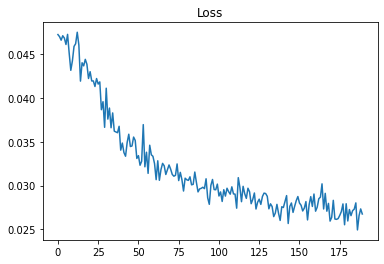

In [263]:
plt.title('Loss')
plt.plot(losses)

In [264]:
def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

In [265]:
model.eval()
test_input = seqsToEncodedVectors([['<s>', 'elizabeth']])
test_input = torch.from_numpy(test_input).double().to(device)
print(test_input.shape)
result = model(test_input)[-1]
print(result)
print(updated_persuasion_model.similar_by_vector(result.detach().cpu().numpy(), topn=6))

torch.Size([1, 2, 200])
tensor([-2.1533e-01, -3.1438e-01, -3.3332e-01, -3.5309e-01, -4.0611e-01,
        -8.7916e-02, -3.4915e-01, -1.0041e-01,  4.7933e-01,  2.6598e-01,
         1.4387e-02, -8.7042e-02,  4.1765e-01, -3.0517e-02, -1.3720e-01,
         5.8412e-01, -4.8515e-01,  3.7479e-01,  6.5168e-01, -3.8892e-01,
         5.1771e-01,  1.2387e+00,  2.0913e-01, -1.6541e-01, -4.8617e-01,
        -1.8841e-01, -2.7102e-01, -4.5119e-01, -2.3440e-02, -1.1940e-01,
        -1.8817e-01,  2.7424e-01,  1.7320e-01, -2.4197e-01, -1.7393e-01,
        -2.8254e-02, -2.6444e-01, -3.0977e-01, -1.5878e-01,  3.9258e-02,
        -4.0729e-01, -3.8234e-01, -6.0593e-01,  2.0325e-01, -1.0402e-01,
        -2.2215e-01,  5.2798e-01,  3.1793e-03,  3.5725e-03,  1.8735e-01,
         8.5480e-02, -3.7276e-02,  2.6647e-02,  1.8912e-01, -7.9534e-02,
        -4.5957e-02, -2.8388e-01, -2.5081e-01, -4.7079e-01, -4.8638e-01,
        -2.4348e-01, -1.4064e-01, -3.9658e-01,  1.6204e-01, -1.2848e-01,
        -3.2458e-01, -6.775

In [266]:
temperature = 0.3

def predict(model, sent):

    # only look at last sample_len - 1 characters

    sent = sent[-(sequence_length - 1):]
    sent = seqsToEncodedVectors([sent])
    sent = torch.from_numpy(sent).double().to(device)

    out = model(sent)[-1]
    predicted_word = updated_persuasion_model.similar_by_vector(out.detach().cpu().numpy(), topn=1)

    return predicted_word[0][0]

def tokenize(sent):
    return sent.lower().split(' ')

predict(model, tokenize('<s> elizabeth'))

'had'

In [267]:
def generate(model, sent):
    for i in range(100):
        sent += [predict(model, sent)]
    return sent

generate(model, tokenize('<s> elizabeth'))

['<s>',
 'elizabeth',
 'had',
 'be',
 'really',
 'same',
 'to',
 'be',
 'knew',
 '</s>',
 '<s>',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'but',
 'and',
 'and',
 'anne',
 'take',
 'come',
 'to',
 'a',
 'but',
 'but',
 'but',
 'but',
 'this',
 'this',
 'be',
 'another',
 'to',
 'this',
 'musgroves',
 'kellynch',
 'but',
 'he',
 'but',
 'but',
 'which',
 'and',
 'that',
 'does',
 'not',
 'but',
 'of',
 'that',
 'she',
 'would',
 'be',
 'but',
 'this',
 'this',
 'as',
 'but',
 'but',
 'but',
 'was',
 'something',
 'and',
 'that',
 'which',
 'was',
 'but',
 'but',
 'that',
 'this',
 'this',
 'this',
 'the',
 'one',
 'all',
 'feelings',
 'but',
 'but',
 'he',
 'would',
 'come',
 'to',
 'not',
 'but',
 'the',
 'same',
 'one',
 'only',
 'but',
 'was',
 'so',
 'rather',
 'this',
 'the']

### Beam Search

Beam search was described, and example shown, in Lecture 14. Here is a brief pseudo-code explaination of what
you need to do:

1. Develop your code as described above so that it can generate single sentences;
2. Copy enough of your code over from HW 03 so that you can calculate the perplexity of
        sentences (using the entire novel, or perhaps even a number of Jane Austen's novels as
        the data source). As an alternative, you may wish to do this separately, store the nested dictionary
        using Pickle, and load it here. 
3. Calculate the probability distribution of sentences in your data source that you used in the previous step, similar to what you did at the end of HW 01. 
4. Create a "goodness function" which estimates the quality of a sentence as the perplexity times the probability of its length.  This will be applied to all sequences of words, and not just sentences, but as a first approximation this is a way to attempt to make the distribution of sentence lengths similar to that in the novel.
5. Follow the description in slide 7 of Lecture 14 to generate until you have 10 finished sentences. Print these out with their perplexity, probability of their length, and the combined goodness metric. 

In [ ]:
# Code here

### Analysis

Describe what experiments you did with various alternatives as described above, and cut and paste examples illustrating your results. 

## Problem Three:  Part-of-Speech Tagging (40 pts)

In this problem, we will experiment with three different approaches to the POS tagging problem, using
the Brown Corpus as our data set. 

Before starting this problem, please review Lecture 13 and download the file <a href="Viterbi.ipynb">Viterbi.ipynb</a> from the 
class web site. 

There are four parts to this problem:

- Part A: You will establish a baseline accuracy for the task. 
- Part B: Using the implementation of the Viterbi algorithm for Hidden Markov Models you downloaded, you will determine how much better than the baseline you can do with this very standard method.
- Part C: You will repeat the exercise of Part B, but using an LSTM implementation, exploring several options for the implementation of the LSTM layer.
- Part D: You will evaluate your results, comparing the various methods in the context of the baseline method from Part A.
- Optional: You may wish to try the same task with a transformer such as Bert. 


Recall that the Brown Corpus has a list of all sentences tagged with parts of speech. The tags are
a bit odd, and not generally used any more, so we will use a much simpler set of tags the `universal_tagset`. 

If you run the following cells, you will see that there are 57,340 sentences, tagged with 12 different tags. 
 

In [ ]:
import numpy as np
import nltk

# The first time you will need to download the corpus:

from nltk.corpus import brown
 
nltk.download('brown')
nltk.download('universal_tagset')

tagged_sentences = brown.tagged_sents(tagset='universal')

print(f'There are {len(tagged_sentences)} sentences tagged with universal POS tags in the Brown Corpus.')
print("\nHere is the first sentence with universal tags:",tagged_sentences[0])

In [ ]:
# Uncomment to see the complete list of tags. 

all_tagged_words = np.concatenate(tagged_sentences)
all_tags = sorted(set([pos for (w,pos) in all_tagged_words]))
print(f'There are {len(all_tags)} universal tags in the Brown Corpus.')
print(all_tags)
print()


### Part A

In this part, you will establish a baseline for the task, using the naive method suggested on slide 35 of Lecture 13:

- Tag every word with its most frequent POS tag (for example, if 'recent' is most frequently tagged as 'ADJ', then assume that every time 'recent' appears in a sentence, it should be tagged with 'ADJ'); 
- If a word has two or more most frequent tags, choose the one that appears first in the list of sorted tags above. 

Note that there will not be any "unknown words." 
 
Use this method to determine your baseline accuracy (it may not be 92% as reported on slide 35!):

- Build a dictionary mapping every word to its most frequent tag;
- Go through the entire tagged corpus, and report the accuracy (percentage of correct tags) of this baseline method. 

Do not tokenize or lower-case the words. Use the words and tags exactly as they are in the tagged sentences. 

### Part B:  

Now, review the `Viterbi.ipynb` notebook and read through Section 8.4 in Jurafsky & Martin to understand the basic approach that is used in the "Janet will back the bill" example. In detail:

- Cut and paste the code from the Viterby notebook below and run your experiments in this notebook. 
- You need to calculate from the Brown Corpus tagged sentences the probabilities for the various matrices used as input to the method:
   - `start_p`: This is the probability that a sentence starts with a given POS (in Figure 8.12 in J & M, this is given as the first line, in the row for `<s>`; simply collect the statistics for the first word in each sentence; it will be of size 1 x 12. 
   - `trans_p`: This is the matrix of probabilities that one POS follows another in a sentence; build a 12 x 12 matrix of frequencies for whether the column POS follows the row POS in a sentence and then normalize each row so that it is a probability distribution (each row should add to 1.0)
   - `emit_p`: This is a matrix of size 12 x N, where N is the number of unique words in the corpus, which for each POS (the row) gives the probability that this POS in the output sequence corresponds to a specific word (the column) in the input sequence; again, you should collect frequency statistics about the relationship between POS and words, and normalize so that every row sums to 1.0. 
   
Then run the algorithm on all the sentences in the tagged corpus, and determine the accuracy of the Viterbi algorithm. Again, the accuracy is calculated on each word, not on sentences as a whole. 

Report your results as a raw accuracy score, and in the two ways that were suggested on slide 12 of Lecture 11: percentage above the baseline established in Part A, and Cohen's Kappa. 

In [ ]:
# Viterbi code should be pasted here

### Part C:  

Next, you will need to develop an LSTM model to solve this problem. You may find it useful to
refer to the following, which presents an approach in Keras.

https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook


You must do the following for this part:

- Develop your code in Pytorch (of course!);
- Use pretrained GloVe embeddings of dimension 200 and update them with the brown sentences; if you run into problems with RAM, you may use a smaller embedding dimension; 
- Truncate all sentences to a maximum of length 100 tokens, and pad shorter sentences (as in the reference above);
- Use an LSTM model and try several different choices for the parameters to the layer:
  - `hidden_size`:  Try several different widths for the layer
  - `bidirectional`: Try unidirectional (False) and bidirectional (True)
  - `num_layers`: Try 1 layer and 2 layers
  - `dropout`: In the case of 2 layers, try several different dropouts, including 0.
- Use early stopping with `patience = 50`;  
You do not have to try every possible combination of these parameter choices; a good strategy is to
try them separately, and then try a couple of combinations of the best choices of each. 

It is your choice about the other hyperparameters.  

Provide a brief discussion of what you discovered, your best loss and accuracy measures for
validation, and three versions of your testing accuracy, as in Part B.  

### Part D:  

Provide an analysis of what experiments you conducted with hyperparameters, what your results were, and in particular comment on how the two methods compare, especially given that one has *no* choice of hyperparameters, and one has *many* choices of parameters. How useful was the flexibility of choice in hyperparameters in Part C?

#### Optional:

You might want to try doing this problem with a transformer model such as BERT. There are plenty of blog posts out there describing the details, and, as usual, chatGPT would have plenty of things to say about the topic.... 